In [41]:
import cmath

import numpy as np
import matplotlib.pyplot as plt

In [87]:
L_X = 10.0
d = 2.0

Re = 1e4
S = 1e4

h = 0.05
pert_n = 1 # This is the wavenumber of the perturbation. It must be an integer.

# N_X should be a power of 4 & N_Z a power of 2 for max speed (See Nvidia cuFFT manual)
N_X = 4**4
N_Z = 2**8

In [91]:
L_Z = 2*d

DX = L_X/(N_X-1)
DZ = L_Z/(N_Z-1)

N_N = int((N_X - 1)/3)
N_M = int((N_Z - 1)/3)

K_N = 2*np.pi/L_X
K_M = 2*np.pi/L_Z

DT = min(DX, DZ)**2 / 4 * 0.9

ooRe = 1/Re
ooS = 1/S

print("Horizontal N:", N_N)
print("Vertical N:", N_M)
print("dt:", DT)

if h*pert_n*K_N < 1:
    print("KH is unstable")

Horizontal N: 85
Vertical N: 85
dt: 5.5363321799307956e-05
KH is unstable


In [76]:
def sech(x):
    return 1/np.cosh(x)

def p2s(M):
    return downscale(np.fft.rfft2(M))/(N_Z*N_X)

def s2p(M):
    return np.fft.irfft2(upscale(M))*N_Z*N_X

def ddx(var):
    result = np.zeros_like(var)
    result[1:-1] = (var[2:] - var[:-2])/(2*DX)
    result[0, :] = (var[1, :] - var[-1, :])/(2*DX)
    result[-1, :] = (var[0, :] - var[-2, :])/(2*DX)
    return result

def ddz(var):
    result = np.zeros_like(var)
    result[:,1:-1] = (var[:,2:] - var[:,:-2])/(2*DZ)
    result[:,0] = (var[:,1] - var[:,-1])/(2*DZ)
    result[:,-1] = (var[:,0] - var[:,-2])/(2*DZ)
    return result

def calc_nl(var, vx, vz):
    result = ddx(var*vx) + ddz(var*vz)
    return p2s(result)

def upscale(M):
    result = np.zeros((N_X, int(N_Z/2)), dtype=np.complex128)
    result[:N_N+1, :N_M] = M[:N_N+1,:]
    result[-N_N:,:N_M] = M[-N_N:,:]
    return result
                      
def downscale(M):
    result = np.zeros((N_N*2+1, N_M), dtype=np.complex128)
    result[:N_N+1, :N_M] = M[:N_N+1, :N_M]
    result[-N_N:, :N_M] = M[-N_N:, :N_M]
    return result

def plot_physical(M):
    plt.imshow(M.T, extent=(0, L_X, -d, d))
    plt.show()

def plot_spectral(M):
    var_p = s2p(M)
    plot_physical(var_p)

## Initial conditions

The initial condition is a Harris sheet where the magnetic field is given by
$$B_0(z) = tanh(z/h),$$
where $h$ is some parameter setting the width of the sheet. Differentiating this to get the current gives
$$j_0(z) = sech^2(z/h)/h.$$

$\omega_0$ is set to $0$

Current profile


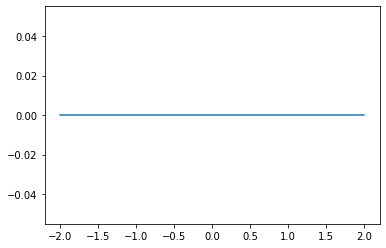

vorticity profile


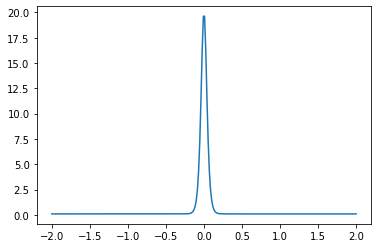

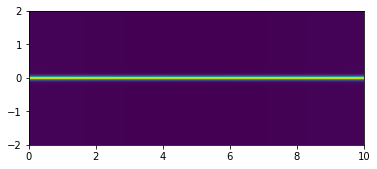

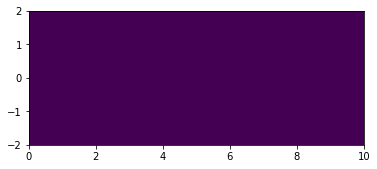

In [88]:
x = np.linspace(0, L_X, N_X)
z = np.linspace(-d, d, N_Z)
X, Z = np.meshgrid(x, z, indexing='ij')
# j0_p = np.power(sech(Z/h), 2)/h
j0_p = X*0
# w0_p = X*0
w0_p = np.power(sech(Z/h), 2)/h

epsilon = 1e-1

# j0_p += epsilon*np.sin(X*h*k)
w0_p += epsilon*np.cos(pert_n*X*K_N)

print("Current profile")
plt.plot(z, j0_p[0])
plt.show()

print("vorticity profile")
plt.plot(z, w0_p[0])
plt.show()

w0 = p2s(w0_p)
j0 = p2s(j0_p)
plot_spectral(w0)
plot_spectral(j0)

In [89]:
# Create mode number matrix
n = np.concatenate((np.arange(0, N_N+1),  np.arange(-N_N, 0)))
m = np.arange(0, N_M)
n, m = np.meshgrid(n, m, indexing='ij')

lap = -((n*K_N)**2 + (m*K_M)**2)
lap[0,0] = 1

w = np.copy(w0)
j = np.copy(j0)

dw_prev = np.zeros_like(w)
dj_prev = np.zeros_like(j)

kes = []

T = 1.0

t = 0
while t < T:
    psi = -w/lap
#     phi = -j/lap
    psi[0,0] = phi[0,0] = 0

    w_p = s2p(w)
#     j_p = s2p(j)

    psi_p = s2p(psi)
#     phi_p = s2p(phi)

    ux_p = ddz(psi_p)
    uz_p = -ddx(psi_p)

    kes += [0.5*np.sum(ux_p**2 + uz_p**2)/(N_X*N_Z)]

#     bx_p = ddz(phi_p)
#     bz_p = -ddx(phi_p)

    dw_curr = -calc_nl(w_p, ux_p, uz_p) + ooRe*lap*w
    
#     dw_curr = -calc_nl(w_p, ux_p, uz_p) + calc_nl(j_p, bx_p, bz_p) + ooRe*lap*w
#     dj_curr = -calc_nl(j_p, ux_p, uz_p) + calc_nl(w_p, bx_p, bz_p) + ooS*lap*j

    w += DT/2*(3*dw_curr - dw_prev)
#     j += DT/2*(3*dj_curr - dj_prev)

    t += DT

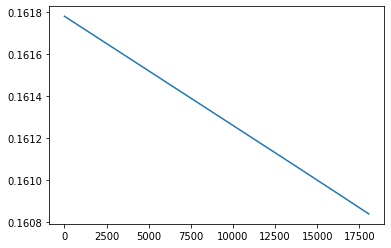

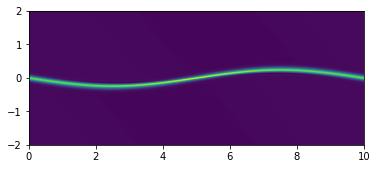

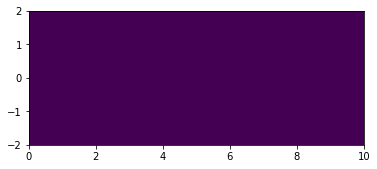

In [94]:
plt.plot(kes)
plt.show()

# plot_physical(psi_p)
# plot_physical(np.roll(psi_p, int(N_X/2), 0))

# plot_physical(ux_p)
# plot_physical(uz_p)
# plot_physical(np.roll(uz_p, int(N_X/2), 0))

plot_spectral(w)
plot_spectral(j)